# Tutorial 2: Integration parameters

## I. Introduction

Now we have covered transmorph basics, let us investigate differences between the different methods and parameters proposed in transmorph. We already used non-regularized discrete optimal transport, but there are many more implemented. Let us start by loading our two favorite datasets as numpy arrays.

In [3]:
from transmorph.datasets import load_spirals, load_spirals_labels
X, Y = load_spirals()
lbl_X, lbl_Y = load_spirals_labels()
X.shape, lbl_X.shape, Y.shape, lbl_Y.shape

((433, 3), (433,), (663, 3), (663,))

As a remainder of the integration goal, let us quickly plot both of them in a common PC space.

In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Computing PCA
pca = PCA(n_components=2)
pca = pca.fit(Y)

# Plotting parameters
dotsize = 40
qcolor = 'royalblue' # query
qmarker = 's'
rcolor = 'crimson' # reference
rmarker = 'o'
icolor = 'yellow' # integrated
imarker = 'D'
x_label = 'PC1'
y_label = 'PC2'
titlesize = 15
labelsize = 15
legendsize = 10

# Plotting function
def plot_datasets(*datasets, 
                   title=None,
                   x_label=None,
                   y_label=None,
                   enable_cbar=False,
                   cbar_title=None,
                   **kwargs):
    for dataset in datasets:
        X = dataset['X']
        color = dataset['c']
        kwargs_to_pass = {k: dataset[k] for k in dataset if k not in ('X', 'c')}
        plt.scatter(*X.T, c=color, **kwargs_to_pass, **kwargs)
    if x_label is not None:
        plt.xlabel(x_label, size=labelsize)
    if y_label is not None:
        plt.ylabel(y_label, size=labelsize)
    if any("label" in dataset for dataset in datasets):
        plt.legend(fontsize=legendsize)
    plt.xticks([])
    plt.yticks([])
    
    if enable_cbar:
        cbar = plt.colorbar()
        if cbar_title is not None:
            cbar.ax.set_ylabel(cbar_title, fontsize=labelsize)
    
    if title is not None:
        plt.title(title, fontsize=titlesize)

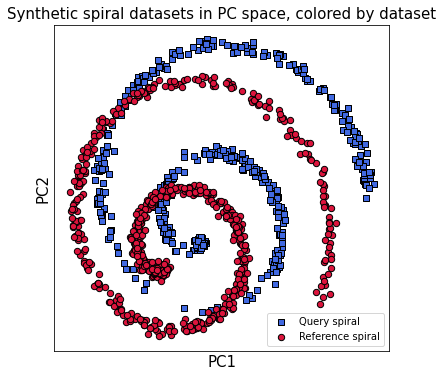

In [6]:
plt.figure(figsize=(6,6))
plot_datasets({
                   "X": pca.transform(X), 
                   "label": "Query spiral",
                   "c": qcolor,
                   "marker": qmarker
               }, 
               {
                   "X": pca.transform(Y), 
                   "label": "Reference spiral",
                   "c": rcolor,
                   "marker": rmarker
               }, 
               title="Synthetic spiral datasets in PC space, colored by dataset",
               x_label=x_label,
               y_label=y_label,
               ec='k', 
               s=dotsize)

We see two datasets in a spiraling fashion. We also observe the query dataset to present "holes" in the manifold, that integration methods will have to account for. There are two main categories of methods in transmorph, distinguished by very different optimization problems: __optimal transport-based__, and __Gromov-Wasserstein based__. Let us first compare the two on our example.

## II. Choosing the right transportation problem

We naturally start by importing the Transmorph object that encapsulates all integration methods.

In [31]:
from transmorph import Transmorph
import time

### 1. Integration parameters

It is important to note that most integration parameters are to be set on Transmorph's construction. Here are some important hyperparameters to choose.
- **method**: this parameter is used to switch between optimal transport and Gromov-Wasserstein formulations. As a rule of thumbs, if you can express a meaningful cost function (like a distance) between samples from different datasets optimal transport seems more appropriate. In the other hand, if each dataset is expressed in a different space (for instance in the multi-omics case), it may be necessary to use separate metrics in the Gromov-Wasserstein framework. In our case, both datasets are embedded in the same space, so we will use optimal transport.
- **entropy**: set it to False (default) to use the exact formulation, and to True to regularize transportation problems with an entropy term. Enabling this parameter usually speeds up computation, at a cost of an extra parameter (regularization factor) and risk of improper convergence.
- **(hreg)**: regularization factor for entropy regularizer, needs tuning
- **unbalanced**: set it to False (default) to use exact marginal constraints, meaning valid transport plans must exactly marginalize to query and reference histograms. Set it to true to use relaxed marginal constraints, meaning transport plans are penalized when they do not marginalize to query and reference histograms. This can help in the case of unbalanced datasets, at a cost of an extra parameter (penalty factor), extra computational time and a less accurate result.
- **(mreg)**: penalty factor for unbalanced formulation, needs tuning

Let us try a simple combination of these. Optimal transport-based, non-entropy regularized with exact marginals and uniform weighting.

In [62]:
t_start = time.time()
transmorph_ot = Transmorph(
    method='ot',  # "ot" for Optimal Transport, "gromov" for Gromov-Wasserstein
    entropy=False,  # Use the entropy regularized formulation (quicker, less accurate)
    unbalanced=False,  # Use the unbalanced transport formulation 
)
X_integrated_ot = transmorph_ot.fit_transform(X, Y)
print("Elapsed:", time.time() - t_start, "seconds")

Elapsed: 0.047214508056640625 seconds


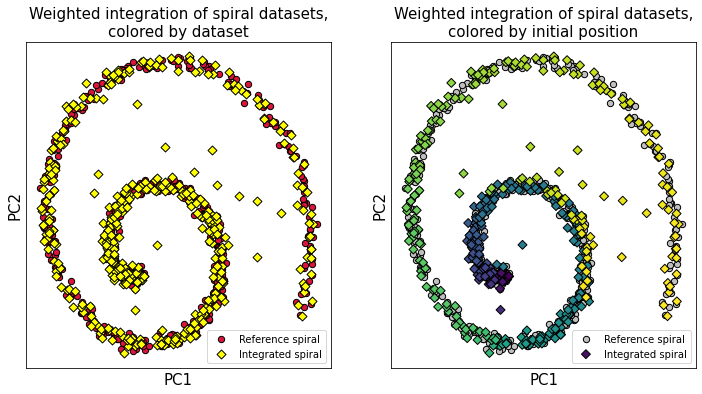

In [64]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plot_datasets({
                   "X": pca.transform(Y), 
                   "label": "Reference spiral",
                   "c": rcolor,
                   "marker": rmarker
               }, 
                {
                   "X": pca.transform(X_integrated_ot), 
                   "label": "Integrated spiral",
                   "c": icolor,
                   "marker": imarker
               }, 
               title="Weighted integration of spiral datasets,\ncolored by dataset",
               x_label=x_label,
               y_label=y_label,
               ec='k', 
               s=dotsize)

plt.subplot(1,2,2)
plot_datasets({
                   "X": pca.transform(Y), 
                   "label": "Reference spiral",
                   "c": 'silver',
                   "marker": rmarker
               }, 
                {
                   "X": pca.transform(X_integrated_ot), 
                   "label": "Integrated spiral",
                   "c": lbl_X,
                   "marker": imarker
               }, 
               title="Weighted integration of spiral datasets,\ncolored by initial position",
               x_label=x_label,
               y_label=y_label,
               ec='k', 
               s=dotsize)

As we have observed in the first tutorial, this simple integration is good in terms of shape, but poor in terms of manifold coherence; this will serve as a "control case". Let us investigate how changeing integration parameters influence the result. Keep in mind tht what works on a dataset may not work on another!

### 2. Method parameter

Let us first switch from optimal transport to Gromov-Wasserstein formulation.

In [65]:
t_start = time.time()
transmorph_gromov = Transmorph(
    method='gromov',  # "ot" for Optimal Transport, "gromov" for Gromov-Wasserstein
    entropy=False,  # Use the entropy regularized formulation (quicker, less accurate)
    unbalanced=False,  # Use the unbalanced transport formulation 
)
X_integrated_gromov = transmorph_gromov.fit_transform(X, Y)
print("Elapsed:", time.time() - t_start, "seconds")

Elapsed: 3.022885322570801 seconds


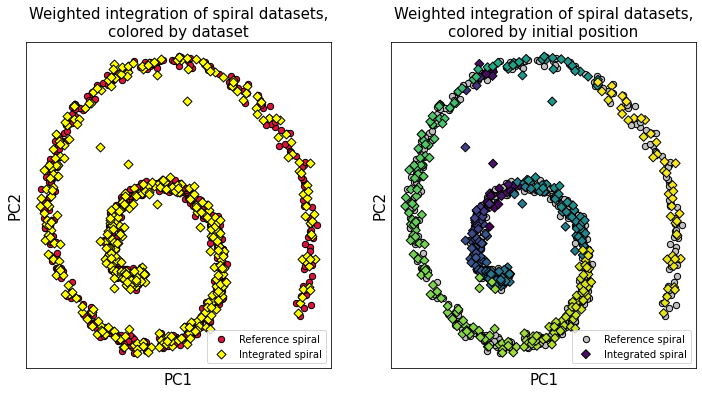

In [66]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plot_datasets({
                   "X": pca.transform(Y), 
                   "label": "Reference spiral",
                   "c": rcolor,
                   "marker": rmarker
               }, 
                {
                   "X": pca.transform(X_integrated_gromov), 
                   "label": "Integrated spiral",
                   "c": icolor,
                   "marker": imarker
               }, 
               title="Weighted integration of spiral datasets,\ncolored by dataset",
               x_label=x_label,
               y_label=y_label,
               ec='k', 
               s=dotsize)

plt.subplot(1,2,2)
plot_datasets({
                   "X": pca.transform(Y), 
                   "label": "Reference spiral",
                   "c": 'silver',
                   "marker": rmarker
               }, 
                {
                   "X": pca.transform(X_integrated_gromov), 
                   "label": "Integrated spiral",
                   "c": lbl_X,
                   "marker": imarker
               }, 
               title="Weighted integration of spiral datasets,\ncolored by initial position",
               x_label=x_label,
               y_label=y_label,
               ec='k', 
               s=dotsize)

This is already an interesting one. As we can see on the left plot, Gromov-Wasserstein formulation has lead to an inversion in the middle of query manifold. This is quite classic, and arise a lot in examples presenting symmetries (for instance, in a multi-cluster dataset). Gromov-Wasserstein can be very appropriate in certain situations though, such as integration in a latent space where rotation can be irrelevant.

### 3. Entropy parameter

Now, let us see the influence of the entropy regularizer on integration. We have to tune its coefficient, **hreg**. The lower the more accurate, but also the longer to compute.

In [67]:
hreg_values = [5e-4, 1e-3, 1e-2, 1e-1, 1]

X_integrated_entropy = {}  # We store the result in a dictionary
for hreg in hreg_values:
    t_start = time.time()
    transmorph_entropy = Transmorph(
        method='ot',  # "ot" for Optimal Transport, "gromov" for Gromov-Wasserstein
        entropy=True,  # Use the entropy regularized formulation (quicker, less accurate)
        hreg=hreg,
        unbalanced=False,  # Use the unbalanced transport formulation 
    )
    X_integrated_entropy[hreg] = transmorph_entropy.fit_transform(X, Y)
    print("hreg:", hreg, "/ elapsed:", time.time() - t_start, "seconds")

hreg: 0.0005 / elapsed: 1.6177449226379395 seconds
hreg: 0.001 / elapsed: 0.6133136749267578 seconds
hreg: 0.01 / elapsed: 0.1349039077758789 seconds
hreg: 0.1 / elapsed: 0.09037208557128906 seconds
hreg: 1 / elapsed: 0.07960009574890137 seconds


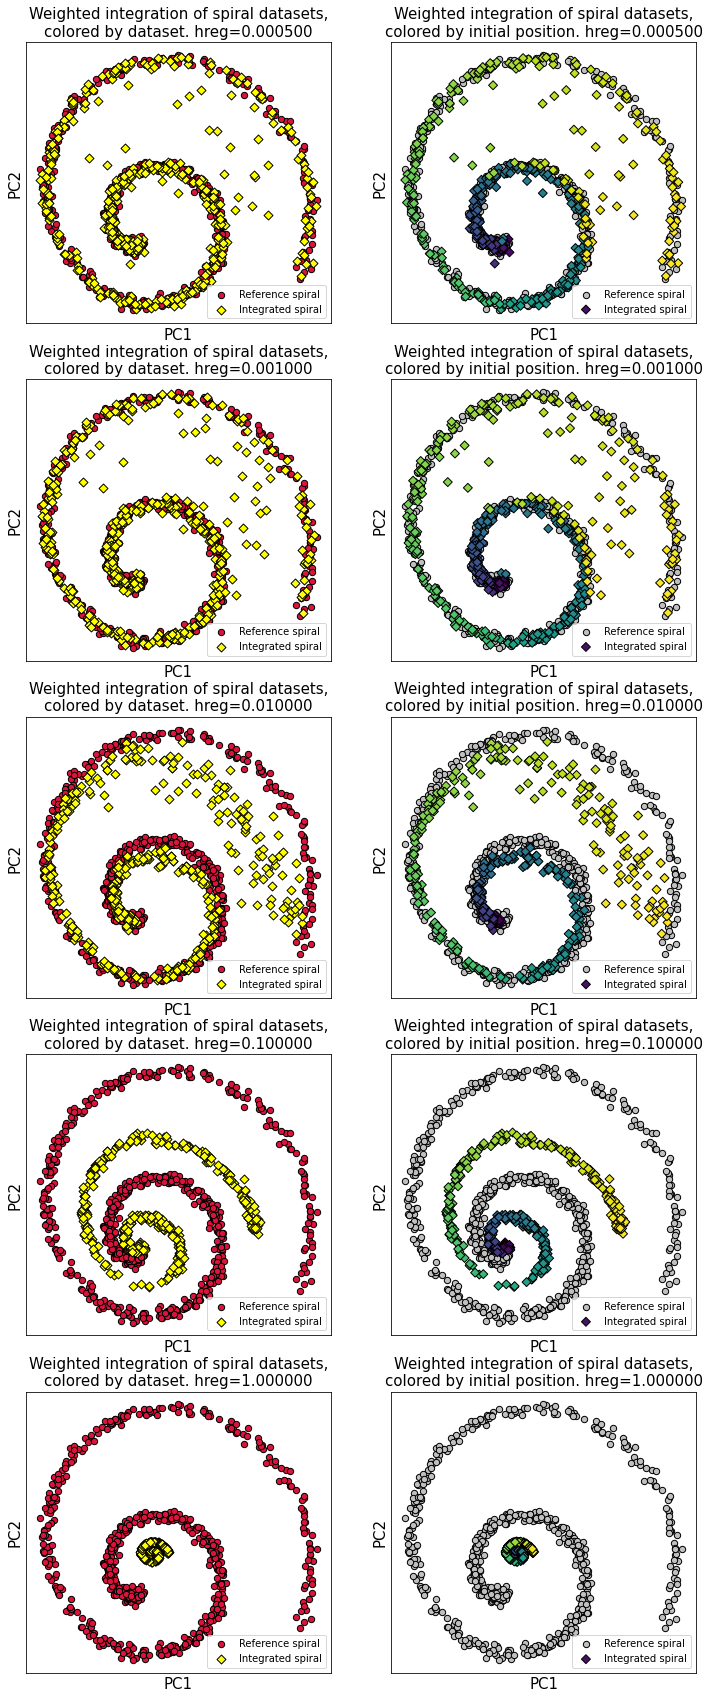

In [68]:
n_hreg = len(hreg_values)
plt.figure(figsize=(12,6*n_hreg))

for i, hreg in enumerate(hreg_values):
    plt.subplot(n_hreg,2,2*i+1)
    plot_datasets({
                       "X": pca.transform(Y), 
                       "label": "Reference spiral",
                       "c": rcolor,
                       "marker": rmarker
                   }, 
                    {
                       "X": pca.transform(X_integrated_entropy[hreg]), 
                       "label": "Integrated spiral",
                       "c": icolor,
                       "marker": imarker
                   }, 
                   title="Weighted integration of spiral datasets,\ncolored by dataset. hreg=%f" % hreg,
                   x_label=x_label,
                   y_label=y_label,
                   ec='k', 
                   s=dotsize)

    plt.subplot(n_hreg,2,2*i+2)
    plot_datasets({
                       "X": pca.transform(Y), 
                       "label": "Reference spiral",
                       "c": 'silver',
                       "marker": rmarker
                   }, 
                    {
                       "X": pca.transform(X_integrated_entropy[hreg]), 
                       "label": "Integrated spiral",
                       "c": lbl_X,
                       "marker": imarker
                   }, 
                   title="Weighted integration of spiral datasets,\ncolored by initial position. hreg=%f" % hreg,
                   x_label=x_label,
                   y_label=y_label,
                   ec='k', 
                   s=dotsize)

We see in these examples the importance of **hreg** parameter tuning, as we clearly understand here the time/quality tradeoff. Also, it is important to note the transportation problems are solved using POT package, which provides a C-accelerated solver for the exact optimal transport problem while the entropy solvers are written in python. Thus, for reasonably sized datasets the exact solver tends to yield better performance than the entropy regularized one.

### 4. Unbalanced formulation

The last parameter I want to cover in the transportation problem choice, is the unbalanced formulation. It allows transport plans not to exactly marginalize to the query/reference histograms, rather penalizing them in proportion of their marginal discrepancy. This can yield convincing results in the case of unbalanced datasets. This feature is only available with the entropy regularized optimal transport formulation and introduces an extra parameter that needs tuning, **mreg** which describes the coefficient of marginal penalty. For the sake of argument, we will fix **hreg** to $5 \times 10^{-4}$ which yielded good results in the previous scenario.

In [69]:
hreg = 5e-4
mreg_values = [1e-2, 1e-1, 1, 10]

X_integrated_unbalanced = {}  # We store the result in a dictionary
for mreg in mreg_values:
    t_start = time.time()
    transmorph_unbalanced = Transmorph(
        method='ot',  # "ot" for Optimal Transport, "gromov" for Gromov-Wasserstein
        entropy=True,  # Use the entropy regularized formulation (quicker, less accurate)
        hreg=hreg,
        unbalanced=True,  # Use the unbalanced transport formulation 
        mreg=mreg,
    )
    X_integrated_unbalanced[mreg] = transmorph_unbalanced.fit_transform(X, Y)
    print("mreg:", mreg, "/ elapsed:", time.time() - t_start, "seconds")

mreg: 0.01 / elapsed: 0.0702519416809082 seconds
mreg: 0.1 / elapsed: 0.31671881675720215 seconds
mreg: 1 / elapsed: 2.0003511905670166 seconds
mreg: 10 / elapsed: 14.16057538986206 seconds


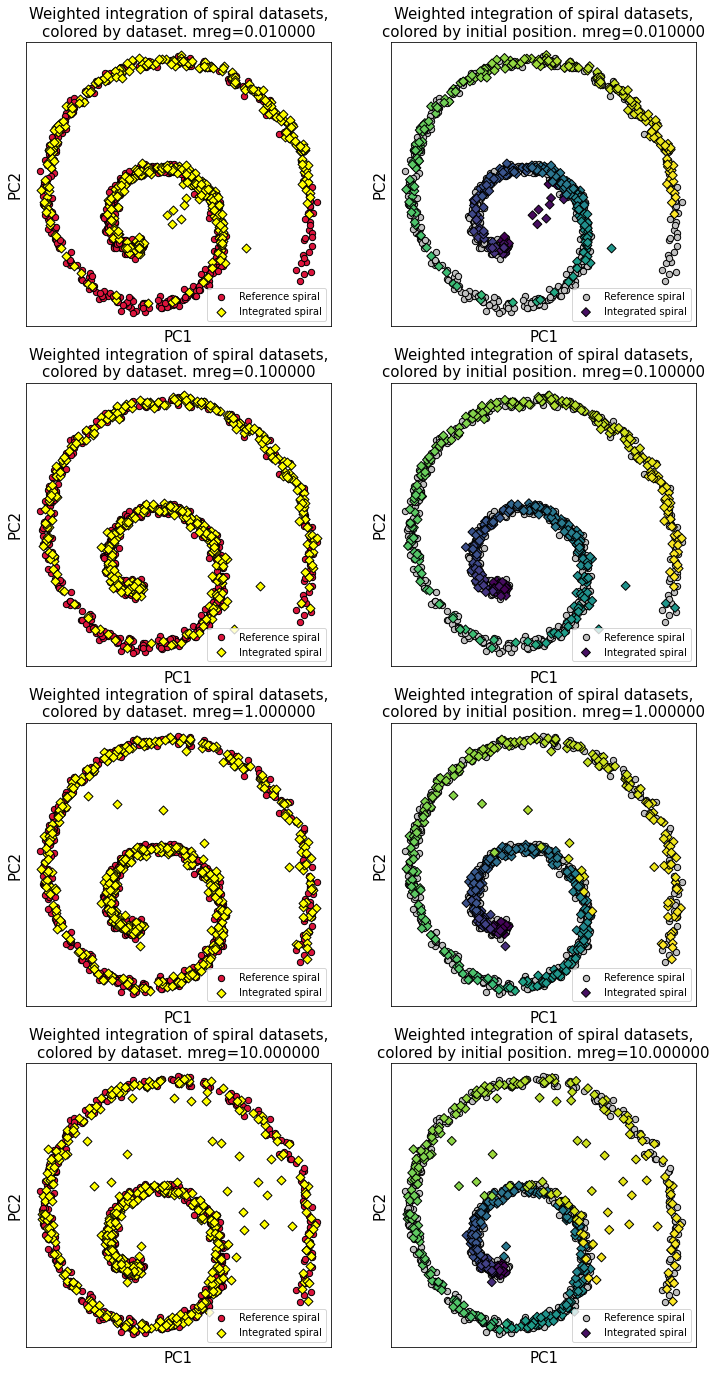

In [70]:
n_mreg = len(mreg_values)
plt.figure(figsize=(12,6*n_mreg))

for i, mreg in enumerate(mreg_values):
    plt.subplot(n_mreg,2,2*i+1)
    plot_datasets({
                       "X": pca.transform(Y), 
                       "label": "Reference spiral",
                       "c": rcolor,
                       "marker": rmarker
                   }, 
                    {
                       "X": pca.transform(X_integrated_unbalanced[mreg]), 
                       "label": "Integrated spiral",
                       "c": icolor,
                       "marker": imarker
                   }, 
                   title="Weighted integration of spiral datasets,\ncolored by dataset. mreg=%f" % mreg,
                   x_label=x_label,
                   y_label=y_label,
                   ec='k', 
                   s=dotsize)

    plt.subplot(n_mreg,2,2*i+2)
    plot_datasets({
                       "X": pca.transform(Y), 
                       "label": "Reference spiral",
                       "c": 'silver',
                       "marker": rmarker
                   }, 
                    {
                       "X": pca.transform(X_integrated_unbalanced[mreg]), 
                       "label": "Integrated spiral",
                       "c": lbl_X,
                       "marker": imarker
                   }, 
                   title="Weighted integration of spiral datasets,\ncolored by initial position. mreg=%f" % mreg,
                   x_label=x_label,
                   y_label=y_label,
                   ec='k', 
                   s=dotsize)

As we can see, the higher **mreg** the closer we get to the balanced formulation. In this example, **mreg=0.1** yields convincing integration results, both in terms of shape, gradient and computation time.

## III. Complementary parameters

We have now reviewed most parameters directly related to the choice of the transportation method. There is a second class of parameters, referred as complementary as they are applied on top of all methods described previously. Let us discuss three of them.
- **metric**: [scipy metric keyword](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html#scipy.spatial.distance.cdist) (default is "sqeuclidean" for squared Euclidean distance), which metric to use in order to build the cost matrix -- or metric matrices for Gromov-Wasserstein.
- **normalize**: set it to True (default is False) to normalize both dataset column-wise with respect to standard deviation, in order to deal with cases where there are strong differences in magnitude between features.
- **weighting\_strategy**: how to attribute sample weights prior to transportation. Either "uniform" (default) or "woti" (see first tutorial) for a weights selection heuristic

### 1. Ground costs

Let us first try different metrics. **Note:** You can use a custom cost matrix by providing it as an argument to the **fit\_transform** method, parameter **Mxy** for optimal transport and **Mx**/**My** for Gromov-Wasserstein.

In [72]:
metrics = [
    "sqeuclidean",
    "euclidean",
    "cosine",
    "canberra",
    "correlation"
]

X_integrated_metrics = {}
for metric in metrics:
    t_start = time.time()
    transmorph_metric = Transmorph(
        metric=metric,  # metric to use in the cost matrix
        normalize=False,  # Normalize X and Y column-wise to account for feature magnitude
        weighting_strategy="uniform"
    )
    X_integrated_metrics[metric] = transmorph_metric.fit_transform(X, Y)
    print("Metric:", metric, "/ Elapsed:", time.time() - t_start, "seconds")

Metric: sqeuclidean / Elapsed: 0.0635993480682373 seconds
Metric: euclidean / Elapsed: 0.052342891693115234 seconds
Metric: cosine / Elapsed: 0.057584285736083984 seconds
Metric: canberra / Elapsed: 0.04465937614440918 seconds
Metric: correlation / Elapsed: 0.07234954833984375 seconds


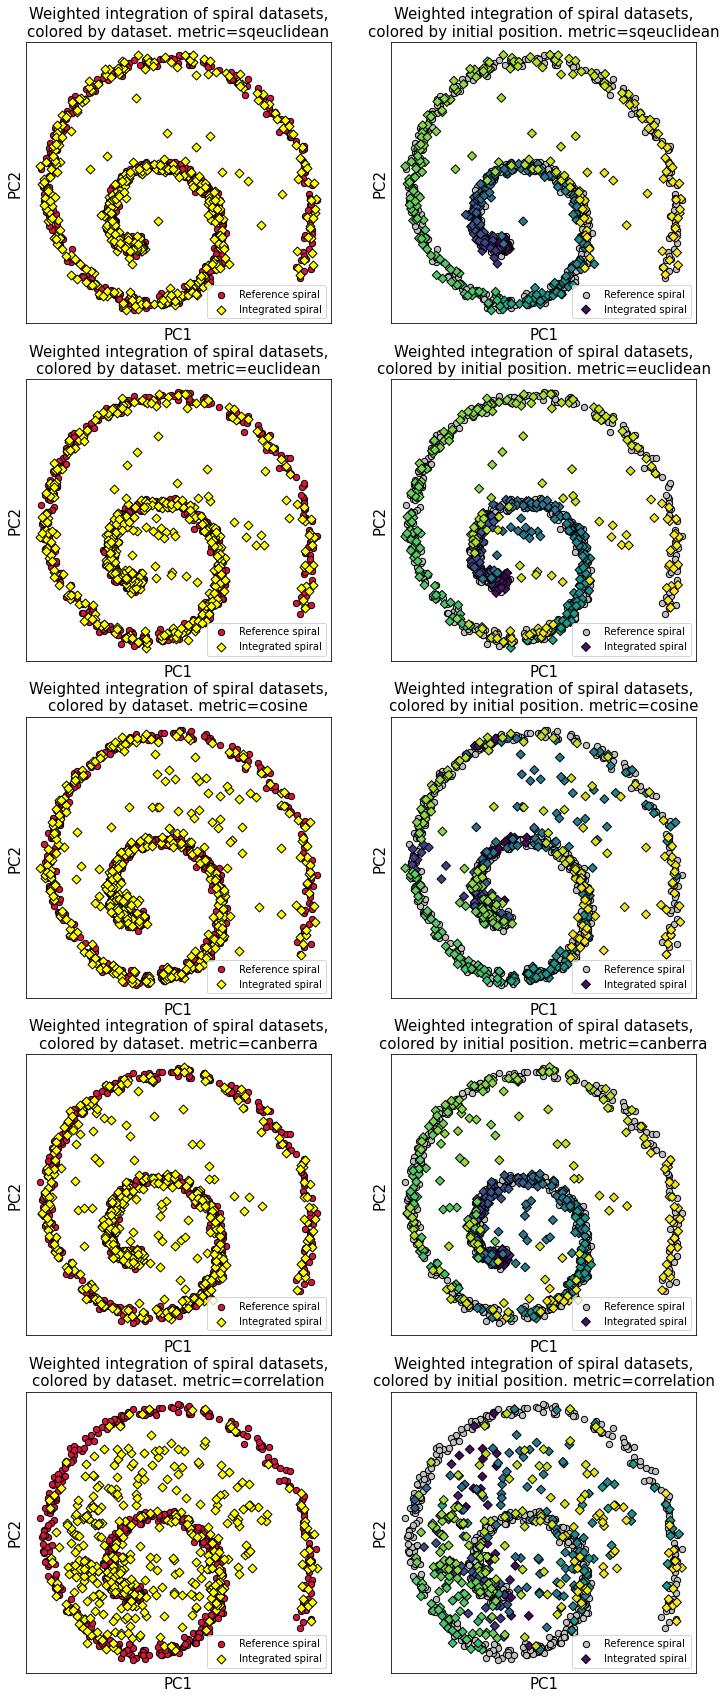

In [73]:
n_metrics = len(metrics)
plt.figure(figsize=(12,6*n_metrics))

for i, metric in enumerate(metrics):
    plt.subplot(n_metrics,2,2*i+1)
    plot_datasets({
                       "X": pca.transform(Y), 
                       "label": "Reference spiral",
                       "c": rcolor,
                       "marker": rmarker
                   }, 
                    {
                       "X": pca.transform(X_integrated_metrics[metric]), 
                       "label": "Integrated spiral",
                       "c": icolor,
                       "marker": imarker
                   }, 
                   title="Weighted integration of spiral datasets,\ncolored by dataset. metric=%s" % metric,
                   x_label=x_label,
                   y_label=y_label,
                   ec='k', 
                   s=dotsize)

    plt.subplot(n_metrics,2,2*i+2)
    plot_datasets({
                       "X": pca.transform(Y), 
                       "label": "Reference spiral",
                       "c": 'silver',
                       "marker": rmarker
                   }, 
                    {
                       "X": pca.transform(X_integrated_metrics[metric]), 
                       "label": "Integrated spiral",
                       "c": lbl_X,
                       "marker": imarker
                   }, 
                   title="Weighted integration of spiral datasets,\ncolored by initial position. metric=%s" % metric,
                   x_label=x_label,
                   y_label=y_label,
                   ec='k', 
                   s=dotsize)

As we can see, metric selection turns out to be at least as important as choosing the proper integration method, with impressive impact on results.

### 2. Feature normalization

Let us retry these different metrics, this time turning on feature normalization, and observe the influence on integration quality.

In [74]:
metrics = [
    "sqeuclidean",
    "euclidean",
    "cosine",
    "canberra",
    "correlation"
]

X_integrated_metrics = {}
for metric in metrics:
    t_start = time.time()
    transmorph_metric = Transmorph(
        metric=metric,  # metric to use in the cost matrix
        normalize=True,  # Normalize X and Y column-wise to account for feature magnitude
        weighting_strategy="uniform"
    )
    X_integrated_metrics[metric] = transmorph_metric.fit_transform(X, Y)
    print("Metric:", metric, "/ Elapsed:", time.time() - t_start, "seconds")

Metric: sqeuclidean / Elapsed: 0.06115579605102539 seconds
Metric: euclidean / Elapsed: 0.049072265625 seconds
Metric: cosine / Elapsed: 0.05976390838623047 seconds
Metric: canberra / Elapsed: 0.046869516372680664 seconds
Metric: correlation / Elapsed: 0.07014012336730957 seconds


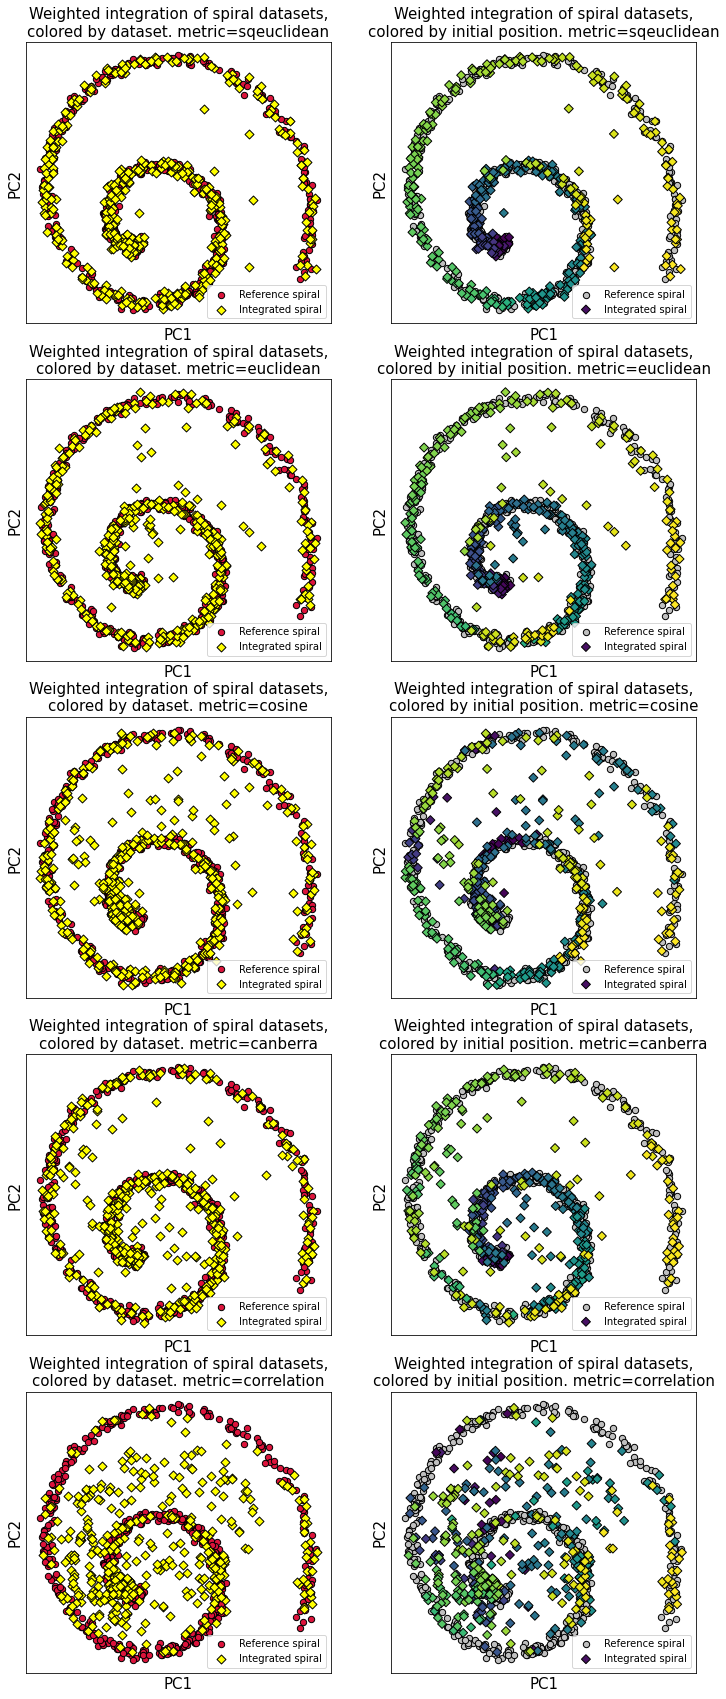

In [75]:
n_metrics = len(metrics)
plt.figure(figsize=(12,6*n_metrics))

for i, metric in enumerate(metrics):
    plt.subplot(n_metrics,2,2*i+1)
    plot_datasets({
                       "X": pca.transform(Y), 
                       "label": "Reference spiral",
                       "c": rcolor,
                       "marker": rmarker
                   }, 
                    {
                       "X": pca.transform(X_integrated_metrics[metric]), 
                       "label": "Integrated spiral",
                       "c": icolor,
                       "marker": imarker
                   }, 
                   title="Weighted integration of spiral datasets,\ncolored by dataset. metric=%s" % metric,
                   x_label=x_label,
                   y_label=y_label,
                   ec='k', 
                   s=dotsize)

    plt.subplot(n_metrics,2,2*i+2)
    plot_datasets({
                       "X": pca.transform(Y), 
                       "label": "Reference spiral",
                       "c": 'silver',
                       "marker": rmarker
                   }, 
                    {
                       "X": pca.transform(X_integrated_metrics[metric]), 
                       "label": "Integrated spiral",
                       "c": lbl_X,
                       "marker": imarker
                   }, 
                   title="Weighted integration of spiral datasets,\ncolored by initial position. metric=%s" % metric,
                   x_label=x_label,
                   y_label=y_label,
                   ec='k', 
                   s=dotsize)

Turning on feature normalization arguably improves integration quality in this example, even if the ranking between metrics does not change.

### 3. Weighting strategy

As a last step, let us compare weighting strategies between uniform and WOTi approaches.

In [79]:
t_start = time.time()
transmorph_uniform = Transmorph(
    metric="sqeuclidean",  # metric to use in the cost matrix
    normalize=False,  # Normalize X and Y column-wise to account for feature magnitude
    weighting_strategy="uniform"
)
X_integrated_uniform = transmorph_uniform.fit_transform(X, Y)
print("Uniform. Elapsed:", time.time() - t_start, "seconds")

t_start = time.time()
transmorph_woti = Transmorph(
    metric="sqeuclidean",  # metric to use in the cost matrix
    normalize=False,  # Normalize X and Y column-wise to account for feature magnitude
    weighting_strategy="woti"
)
X_integrated_woti = transmorph_woti.fit_transform(X, Y)
print("WOTi. Elapsed:", time.time() - t_start, "seconds")

Uniform. Elapsed: 0.051390647888183594 seconds
WOTi. Elapsed: 0.34537339210510254 seconds


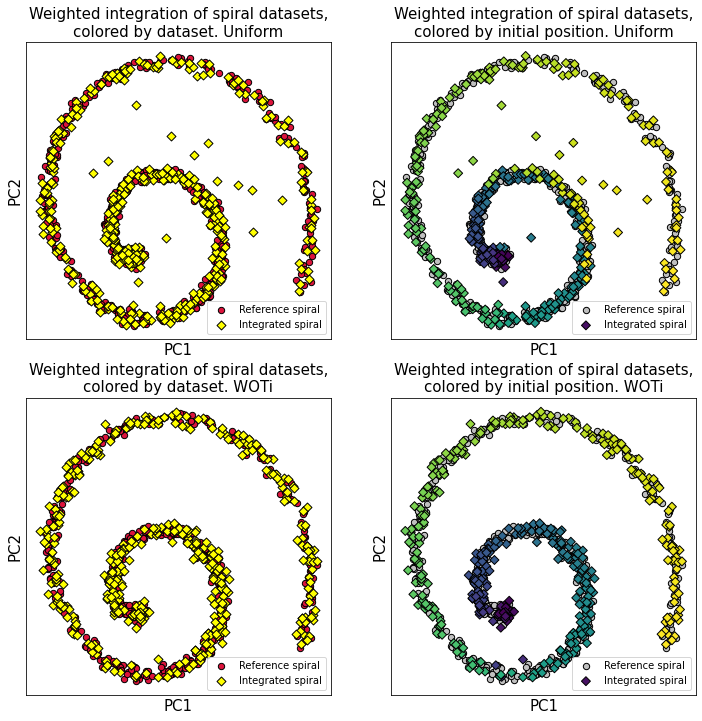

In [77]:
plt.figure(figsize=(12,12))

plt.subplot(2,2,1)
plot_datasets({
                   "X": pca.transform(Y), 
                   "label": "Reference spiral",
                   "c": rcolor,
                   "marker": rmarker
               }, 
                {
                   "X": pca.transform(X_integrated_uniform), 
                   "label": "Integrated spiral",
                   "c": icolor,
                   "marker": imarker
               }, 
               title="Weighted integration of spiral datasets,\ncolored by dataset. Uniform",
               x_label=x_label,
               y_label=y_label,
               ec='k', 
               s=dotsize)

plt.subplot(2,2,2)
plot_datasets({
                   "X": pca.transform(Y), 
                   "label": "Reference spiral",
                   "c": 'silver',
                   "marker": rmarker
               }, 
                {
                   "X": pca.transform(X_integrated_uniform), 
                   "label": "Integrated spiral",
                   "c": lbl_X,
                   "marker": imarker
               }, 
               title="Weighted integration of spiral datasets,\ncolored by initial position. Uniform",
               x_label=x_label,
               y_label=y_label,
               ec='k', 
               s=dotsize)

plt.subplot(2,2,3)
plot_datasets({
                   "X": pca.transform(Y), 
                   "label": "Reference spiral",
                   "c": rcolor,
                   "marker": rmarker
               }, 
                {
                   "X": pca.transform(X_integrated_woti), 
                   "label": "Integrated spiral",
                   "c": icolor,
                   "marker": imarker
               }, 
               title="Weighted integration of spiral datasets,\ncolored by dataset. WOTi",
               x_label=x_label,
               y_label=y_label,
               ec='k', 
               s=dotsize)

plt.subplot(2,2,4)
plot_datasets({
                   "X": pca.transform(Y), 
                   "label": "Reference spiral",
                   "c": 'silver',
                   "marker": rmarker
               }, 
                {
                   "X": pca.transform(X_integrated_woti), 
                   "label": "Integrated spiral",
                   "c": lbl_X,
                   "marker": imarker
               }, 
               title="Weighted integration of spiral datasets,\ncolored by initial position. WOTi",
               x_label=x_label,
               y_label=y_label,
               ec='k', 
               s=dotsize)

As in the first tutorial, we observe WOTi weighting to convincingly correct for density unbalance, and provide faithful integration.

## IV. Putting all together

To wrap up this second tutorial, let us build a Transmorph object with all parameters we found convincing in our examples.

In [78]:
t_start = time.time()
transmorph_final = Transmorph(
    method="ot",
    entropy=False,
    unbalanced=False,
    metric="sqeuclidean",  # metric to use in the cost matrix
    normalize=True,  # Normalize X and Y column-wise to account for feature magnitude
    weighting_strategy="woti"
)
X_integrated_final = transmorph_final.fit_transform(X, Y)
print("Final transmorph. Elapsed:", time.time() - t_start, "seconds")

Final transmorph. Elapsed: 0.5027694702148438 seconds


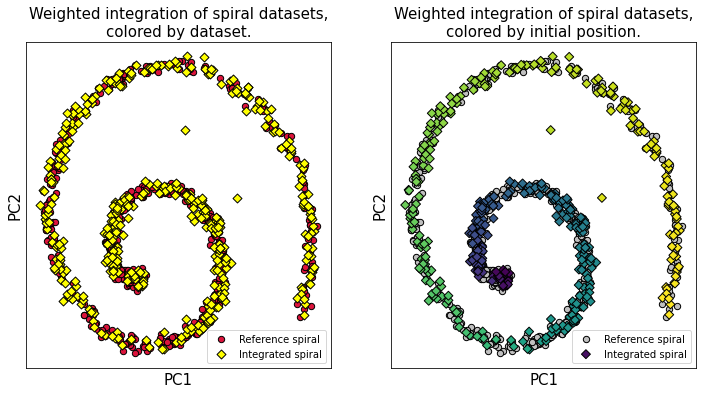

In [80]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plot_datasets({
                   "X": pca.transform(Y), 
                   "label": "Reference spiral",
                   "c": rcolor,
                   "marker": rmarker
               }, 
                {
                   "X": pca.transform(X_integrated_final), 
                   "label": "Integrated spiral",
                   "c": icolor,
                   "marker": imarker
               }, 
               title="Weighted integration of spiral datasets,\ncolored by dataset.",
               x_label=x_label,
               y_label=y_label,
               ec='k', 
               s=dotsize)

plt.subplot(1,2,2)
plot_datasets({
                   "X": pca.transform(Y), 
                   "label": "Reference spiral",
                   "c": 'silver',
                   "marker": rmarker
               }, 
                {
                   "X": pca.transform(X_integrated_final), 
                   "label": "Integrated spiral",
                   "c": lbl_X,
                   "marker": imarker
               }, 
               title="Weighted integration of spiral datasets,\ncolored by initial position.",
               x_label=x_label,
               y_label=y_label,
               ec='k', 
               s=dotsize)

In the next tutorial, we will use real single-cell data and discover Transmorph scalability options to deal with large datasets. :-)